In [ ]:
# ============================================================
# 🧠 DenseNet121 Classification Brain Tumor Dataset
# ============================================================

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ============================================================
# 1️⃣ Vérification GPU
# ============================================================
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Si tu veux forcer le CPU, décommente :
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ============================================================
# 2️⃣ Extraction du ZIP
# ============================================================

extract_path = r"/content/drive/MyDrive/TumourDL/archive (2)"
os.makedirs(extract_path, exist_ok=True)



# ============================================================
# 3️⃣ Chemins vers les données
# ============================================================
train_dir = os.path.join(extract_path, "Training")
test_dir  = os.path.join(extract_path, "Testing")

# ============================================================
# 4️⃣ Préparation des données
# ============================================================
img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ============================================================
# 5️⃣ Construction du modèle DenseNet121 avec fine-tuning
# ============================================================
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Bloquer les poids pour le premier entraînement
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ============================================================
# 6️⃣ Compilation
# ============================================================
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ============================================================
# 7️⃣ Callbacks
# ============================================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('densenet_brain_tumor.h5', monitor='val_loss', save_best_only=True)

# ============================================================
# 8️⃣ Entraînement initial (features extraction)
# ============================================================
epochs = 20

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

# ============================================================
# 9️⃣ Fine-tuning : débloquer les dernières couches
# ============================================================
for layer in base_model.layers[-50:]:  # débloquer les 50 dernières couches
    layer.trainable = True

# Recompiler avec un learning rate plus petit
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement fine-tuning
epochs_finetune = 20
history_ft = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs_finetune,
    callbacks=[early_stop, checkpoint]
)

# ============================================================
# 🔟 Évaluation finale sur test set
# ============================================================
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc*100:.2f}%")


Num GPUs Available:  1
Found 5712 images belonging to 4 classes.
Found 1310 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7223 - loss: 0.7966

357/357 ━━━━━━━━━━━━━━━━━━━━ 1601s 4s/step - accuracy: 0.7225 - loss: 0.7959 - val_accuracy: 0.8443 - val_loss: 0.4230
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8572 - loss: 0.3922

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 283ms/step - accuracy: 0.8572 - loss: 0.3922 - val_accuracy: 0.8687 - val_loss: 0.3503
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.8657 - loss: 0.3487 - val_accuracy: 0.8511 - val_loss: 0.3783
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8856 - loss: 0.3042

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.8856 - loss: 0.3043 - val_accuracy: 0.8710 - val_loss: 0.3422
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8909 - loss: 0.2876

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 284ms/step - accuracy: 0.8909 - loss: 0.2876 - val_accuracy: 0.8641 - val_loss: 0.3421
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8964 - loss: 0.2819

357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 285ms/step - accuracy: 0.8964 - loss: 0.2819 - val_accuracy: 0.8969 - val_loss: 0.2794
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 281ms/step - accuracy: 0.9008 - loss: 0.2686 - val_accuracy: 0.8855 - val_loss: 0.2830
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9069 - loss: 0.2607

357/357 ━━━━━━━━━━━━━━━━━━━━ 100s 281ms/step - accuracy: 0.9069 - loss: 0.2607 - val_accuracy: 0.8924 - val_loss: 0.2635
Epoch 9/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9010 - loss: 0.2660

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 284ms/step - accuracy: 0.9010 - loss: 0.2660 - val_accuracy: 0.9008 - val_loss: 0.2412
Epoch 10/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9150 - loss: 0.2343

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.9150 - loss: 0.2343 - val_accuracy: 0.9069 - val_loss: 0.2247
Epoch 11/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 100s 279ms/step - accuracy: 0.9210 - loss: 0.2185 - val_accuracy: 0.8962 - val_loss: 0.2516
Epoch 12/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.9073 - loss: 0.2421 - val_accuracy: 0.9069 - val_loss: 0.2254
Epoch 13/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 100s 280ms/step - accuracy: 0.9139 - loss: 0.2295 - val_accuracy: 0.8855 - val_loss: 0.2655
Epoch 14/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 283ms/step - accuracy: 0.9263 - loss: 0.2113 - val_accuracy: 0.9038 - val_loss: 0.2493
Epoch 15/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 99s 278ms/step - accuracy: 0.9242 - loss: 0.2056 - val_accuracy: 0.8794 - val_loss: 0.3104
Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 158s 338ms/step - accuracy: 0.5499 - loss: 2.3894 - val_accuracy: 0.8794 - val_loss: 0.4075
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.8205 - loss: 

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 286ms/step - accuracy: 0.8981 - loss: 0.3134 - val_accuracy: 0.9206 - val_loss: 0.2209
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9004 - loss: 0.2774

357/357 ━━━━━━━━━━━━━━━━━━━━ 103s 289ms/step - accuracy: 0.9004 - loss: 0.2773 - val_accuracy: 0.9229 - val_loss: 0.2157
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9191 - loss: 0.2338

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 284ms/step - accuracy: 0.9191 - loss: 0.2338 - val_accuracy: 0.9244 - val_loss: 0.1966
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9188 - loss: 0.2167

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 285ms/step - accuracy: 0.9188 - loss: 0.2167 - val_accuracy: 0.9260 - val_loss: 0.1912
Epoch 9/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9257 - loss: 0.2011

357/357 ━━━━━━━━━━━━━━━━━━━━ 143s 289ms/step - accuracy: 0.9257 - loss: 0.2011 - val_accuracy: 0.9313 - val_loss: 0.1893
Epoch 10/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9367 - loss: 0.1819

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 285ms/step - accuracy: 0.9367 - loss: 0.1820 - val_accuracy: 0.9282 - val_loss: 0.1847
Epoch 11/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9365 - loss: 0.1747

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 284ms/step - accuracy: 0.9365 - loss: 0.1747 - val_accuracy: 0.9359 - val_loss: 0.1603
Epoch 12/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.9418 - loss: 0.1648 - val_accuracy: 0.9336 - val_loss: 0.1604
Epoch 13/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 284ms/step - accuracy: 0.9401 - loss: 0.1679 - val_accuracy: 0.9351 - val_loss: 0.1605
Epoch 14/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9391 - loss: 0.1651

357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.9391 - loss: 0.1651 - val_accuracy: 0.9412 - val_loss: 0.1464
Epoch 15/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9460 - loss: 0.1510

357/357 ━━━━━━━━━━━━━━━━━━━━ 103s 287ms/step - accuracy: 0.9460 - loss: 0.1510 - val_accuracy: 0.9435 - val_loss: 0.1425
Epoch 16/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9525 - loss: 0.1413

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 286ms/step - accuracy: 0.9525 - loss: 0.1413 - val_accuracy: 0.9443 - val_loss: 0.1403
Epoch 17/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 282ms/step - accuracy: 0.9460 - loss: 0.1361 - val_accuracy: 0.9420 - val_loss: 0.1411
Epoch 18/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9478 - loss: 0.1359

357/357 ━━━━━━━━━━━━━━━━━━━━ 102s 285ms/step - accuracy: 0.9479 - loss: 0.1359 - val_accuracy: 0.9435 - val_loss: 0.1306
Epoch 19/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9580 - loss: 0.1180

357/357 ━━━━━━━━━━━━━━━━━━━━ 103s 287ms/step - accuracy: 0.9580 - loss: 0.1180 - val_accuracy: 0.9489 - val_loss: 0.1204
Epoch 20/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 284ms/step - accuracy: 0.9575 - loss: 0.1103 - val_accuracy: 0.9443 - val_loss: 0.1230
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9289 - loss: 0.1610

Test Accuracy: 94.89%


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# ============================================================
# 1️⃣ Charger le modèle entraîné
# ============================================================
model = load_model('/content/drive/MyDrive/TumourDL/densenet_brain_tumor.h5')

# ============================================================
# 2️⃣ Chemin vers l'image à tester
# ============================================================
img_path = '/content/drive/MyDrive/TumourDL/archive (2)/Testing/pituitary/Te-pi_0216.jpg'  # Remplace par ton image

# ============================================================
# 3️⃣ Préparation de l'image
# ============================================================
img = image.load_img(img_path, target_size=(224, 224))  # taille DenseNet121
img_array = image.img_to_array(img)
img_array = img_array / 255.0          # normalisation comme pour l'entraînement
img_array = np.expand_dims(img_array, axis=0)  # ajouter la dimension batch

# ============================================================
# 4️⃣ Prédiction
# ============================================================
preds = model.predict(img_array)
class_idx = np.argmax(preds, axis=1)[0]

# Obtenir le mapping des classes
class_labels = list(train_generator.class_indices.keys())

print(f"Classe prédite: {class_labels[class_idx]}")
print(f"Probabilités: {preds}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Classe prédite: pituitary
Probabilités: [[2.90655826e-05 1.10307574e-01 3.29205138e-03 8.86371255e-01]]


In [ ]:
# ============================================================
# 🔄 Recharger modèle + historique
# ============================================================

from tensorflow.keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1️⃣ Charger le modèle
model_path = '/content/drive/MyDrive/TumourDL/densenet_brain_tumor.h5'
model = load_model(model_path)
print("✅ Modèle chargé.")

# 2️⃣ Charger l'historique si disponible
try:
    with open('history.pkl', 'rb') as f:
        history = pickle.load(f)
    with open('history_ft.pkl', 'rb') as f:
        history_ft = pickle.load(f)
    print("✅ Historique chargé.")
    history_available = True
except:
    print("⚠️ Historique non disponible. Les courbes ne seront pas tracées.")
    history_available = False

# ============================================================
# 🔹 Fonctions utilitaires
# ============================================================

# Combiner deux historiques
def combine_histories(hist1, hist2):
    combined = {}
    for key in set(list(hist1.keys()) + list(hist2.keys())):
        vals = []
        if key in hist1:
            vals.extend(hist1[key])
        if key in hist2:
            vals.extend(hist2[key])
        combined[key] = vals
    return combined

# Tracer courbes loss/accuracy
def plot_training_history_dict(hist_dict):
    epochs = range(1, len(next(iter(hist_dict.values()))) + 1)
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist_dict['loss'], label='train loss')
    plt.plot(epochs, hist_dict['val_loss'], label='val loss')
    plt.title('Évolution de la perte')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    if 'accuracy' in hist_dict:
        plt.plot(epochs, hist_dict['accuracy'], label='train acc')
    if 'val_accuracy' in hist_dict:
        plt.plot(epochs, hist_dict['val_accuracy'], label='val acc')
    plt.title('Évolution de la précision')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Matrice de confusion + rapport
def plot_confusion_from_generator(model, generator):
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    y_pred = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Matrice de confusion (normalisée)")
    plt.show()

    print("\nRapport de classification :")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# ============================================================
# 🔹 Exécution
# ============================================================

# Tracer courbes si historique disponible
if history_available:
    history_combined = combine_histories(history, history_ft)
    plot_training_history_dict(history_combined)

# Tracer matrice de confusion (nécessite test_generator)
# Remplace ce chemin par ton test_generator si tu es en notebook
# Exemple si tu as déjà défini test_generator dans ton notebook
# plot_confusion_from_generator(model, test_generator)


✅ Modèle chargé.
⚠️ Historique non disponible. Les courbes ne seront pas tracées.


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔹 Chemins vers les données
extract_path = r"/content/drive/MyDrive/TumourDL/archive (2)"
test_dir  = os.path.join(extract_path, "Testing")

# 🔹 Paramètres
img_size = (224, 224)
batch_size = 16

# 🔹 Générateur de test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1310 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step


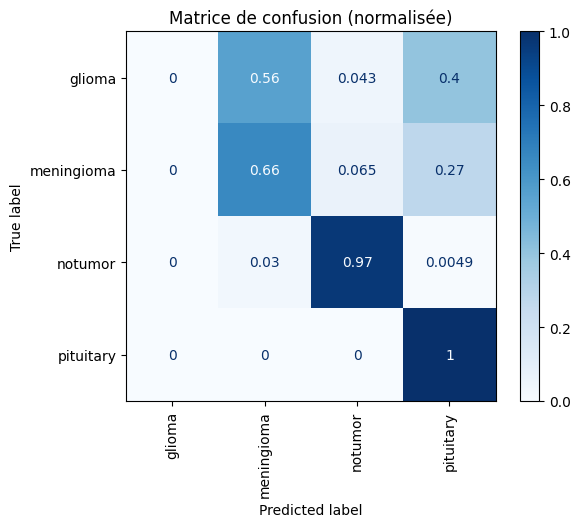


Rapport de classification :
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       299
  meningioma       0.53      0.66      0.59       306
     notumor       0.92      0.97      0.94       405
   pituitary       0.59      1.00      0.74       300

    accuracy                           0.68      1310
   macro avg       0.51      0.66      0.57      1310
weighted avg       0.55      0.68      0.60      1310



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Recompiler pour supprimer le warning (optionnel)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tracer matrice de confusion
plot_confusion_from_generator(model, test_generator)
